# Enrichment analysis workflow for molecular QTL results

For molecular QTL analysis results we obtained we'd like to see if:

1. PIP are higher on average in certain annotation groups than in the rest of genome
2. Is there an enrichment for variables both in CS and in some annotation groups
    - Specifically, whether or not there is an enrichment in the secondary CS that we capture
    
We focus only on the results that has 1 or more CS identified.

## Annotations used for splice QTL

We use the following types of annotations:

1. Histone marks for LCLs from Epigenome Roadmap (download link see pipeline below)
2. [CTCF binding sites](http://www.ebi.ac.uk/birney-srv/CTCF-QTL/)
3. POL II ChIP-seq (download link see pipeline below)
4. Intron and exon regions from UCSC
5. Extended splice site, defined as 5bp up/down intron start site and 15bp up/down intron end site (based on UCSC intron data)

I will first test for enrichment with the primary CS (defined as the set with highest purity), then test for the non-primary CS. The idea is to discover enrichment of annotations in the primary CS, then also show that additional CS has similar (or interestingly different!) pattern of enrichment.

In [1]:
%revisions -s -n 10

Revision,Author,Date,Message
aeff0d4,Gao Wang,2018-09-07,Update enrichment analysis data path
f3b5e0e,Gao Wang,2018-09-06,Update analysis data path
6ffe8e6,Gao Wang,2018-09-05,Update CS summary
27f917a,Gao Wang,2018-08-16,Plot enrichment results
1ccb004,Gao Wang,2018-08-16,Use PIP cutoff 0.2 for enrichment test
b9812cb,Gao Wang,2018-08-15,Add check with matrixqtl results
dd86c4b,Gao Wang,2018-08-14,Update enrichment analysis
9e348be,Gao Wang,2018-08-13,Update enrichment analysis
08a8685,Gao Wang,2018-07-31,Make input zscore file a parameter for GREGOR analysis of other data-sets
d7b6d17,Gao Wang,2018-07-24,Add GREGOR results


In [2]:
! sos run 20180712_Enrichment_Workflow.ipynb -h

usage: sos run 20180712_Enrichment_Workflow.ipynb
               [workflow_name | -t targets] [options] [workflow_options]
  workflow_name:        Single or combined workflows defined in this script
  targets:              One or more targets to generate
  options:              Single-hyphen sos parameters (see "sos run -h" for details)
  workflow_options:     Double-hyphen workflow-specific parameters

Workflows:
  extract_sumstats
  zscore2bed
  get_variants
  range2var_annotation
  pip_rank_test
  cs_fisher_test

Global Workflow Options:
  --y-data . (as path)
                        Y data, the phenotype file paths
  --trait VAL (required)
                        Trait name
  --cwd  path(f'{y_data:d}/{trait}_output')

                        Specify work / output directory
  --annotation-dir /home/gaow/Documents/GIT/LargeFiles/he_lab_annotations_bed (as path)
                        Path to directory of annotation
                        files
  --single-annot . (as path)
         

## Annotation input


Annotation files are in bed format (for example: `Coding_UCSC.bed`).

```
chr1    69090   70008
chr1    367658  368597
chr1    621095  622034
......
chr9    141121357       141121553
chr9    141124188       141124276
chr9    141134069       141134172
```

There are many annotations one can use. For this workflow one should prepare a list of annotations for input, like this:

```
# my annotation
Coding_UCSC
CTCF_binding
E116-DNase.macs2
E116-H2A.Z
E116-H3K27ac
E116-H3K27me3
E116-H3K36me3
E116-H3K4me1
E116-H3K4me2
E116-H3K4me3
E116-H3K79me2
E116-H3K9ac
E116-H3K9me3
E116-H4K20me1
E117-DNase.macs2
Intron_UCSC
PolII_binding
```

comment symbol `#` is allowed.

## Data input

Need to format the data to:

```
Variant_ID PIP z_score CS_ID 
```

Where `CS_ID` is 0 if variant is not in SuSiE CS, 1 if in CS 1, 2 in CS 2, etc. `Variant_ID` carries information of chrom and pos. eg, `rs10131831_chr14_20905250_G_A`

In [ ]:
[global]
# Y data, the phenotype file paths
parameter: y_data = path()
# Trait name
parameter: trait = None
# Specify work / output directory
parameter: cwd = path(f'{y_data:d}/{trait}_output')
# Path to directory of annotation files
parameter: annotation_dir = path('/project/compbio/jointLCLs/annotations/susie_paper_annotations')
# Path to list of single annotations to use
parameter: single_annot = path() #parameter: single_annot = path("data/all_annotations.txt")
# Maximum distance to site of interest, set to eg. 100Kb or 1Mb up/downstream to start site of analysis unit
parameter: max_dist = 100000
fail_if(not y_data.is_file(), msg = 'Please provide valid ``--y-data``!')
parameter: z_score = path(f'{cwd}/{y_data:bnn}_{int(max_dist/1000)}Kb/enrichment/SuSiE_loci.sumstats.gz')
out_dir = f'{cwd}/{y_data:bnn}_{int(max_dist/1000)}Kb/enrichment/{z_score:bn}'.replace('.', '_')
try:
    single_anno = [f"{annotation_dir}/{x.split()[0]}.bed" for x in open(single_annot).readlines() if not x.startswith('#')]
except (FileNotFoundError, IsADirectoryError):
    single_anno = []

and some bash variables:

```
xdata=/project/compbio/jointLCLs/genotype/hg19/YRI/genotypesYRI.gen.txt.gz
ydata=/project/compbio/jointLCLs/phenotypes/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF.txt.gz
ncpu=16
trait=AS
cwd=/project/compbio/jointLCLs/results/SuSiE
```

## Software resource

Initially I've got all my tools dockerized. Unfortunately it is not straightforward to run docker (or singularity, yet) on UChicago cluster. I will add in here the notes to install needed software to markdown cells near relevant workflow steps.

## Prepare annotations

Histone marks

```
sos run analysis/20180712_Enrichment_Workflow.ipynb download_histone_annotation \
    --trait $trait --y-data $ydata
```

Need to install `bedops`:

```
conda install -c bioconda bedops 
```

In [ ]:
[download_histone_annotation]
depends: executable('sort-bed')
dataset = paths(["E116-DNase.macs2.narrowPeak.gz",
"E116-H2A.Z.narrowPeak.gz",
"E116-H3K4me1.narrowPeak.gz",
"E116-H3K4me2.narrowPeak.gz",
"E116-H3K4me3.narrowPeak.gz",
"E116-H3K9ac.narrowPeak.gz",
"E116-H3K9me3.narrowPeak.gz",
"E116-H3K27ac.narrowPeak.gz",
"E116-H3K27me3.narrowPeak.gz",
"E116-H3K36me3.narrowPeak.gz",
"E116-H3K79me2.narrowPeak.gz",
"E116-H4K20me1.narrowPeak.gz"])
input: for_each = 'dataset', concurrent = True
output: f'{annotation_dir}/{_dataset:nn}.bed'
download: dest_dir = annotation_dir, expand = True
    https://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/narrowPeak/{_dataset}
bash: expand = True, workdir = annotation_dir
    zcat {_dataset} | cut -f1-3 | grep -v chrM | sort-bed - > {_output}

CTCF binding:

```
sos run analysis/20180712_Enrichment_Workflow.ipynb download_ctcf_annotation \
    --trait $trait --y-data $ydata
```

In [ ]:
[download_ctcf_annotation]
depends: executable('sort-bed')
output: f'{annotation_dir}/CTCF_binding.bed'
download: dest_dir = annotation_dir
    https://www.ebi.ac.uk/birney-srv/CTCF-QTL/phenotypes/bindings.csv
bash: expand = True, workdir = annotation_dir
    cut -f1-3 -d "," bindings.csv | tail -n+2 | sed 's/,/\t/g' | sed 's/^/chr/g' | grep -v chrM | sort-bed - > {_output}

PolyII binding:

```
sos run analysis/20180712_Enrichment_Workflow.ipynb download_polII_annotation \
    --trait $trait --y-data $ydata
```

Need to `liftOver`:

```
conda config --add channels bioconda
conda install ucsc-liftover
```

In [ ]:
[download_polII_annotation]
depends: executable('sort-bed'), executable('liftOver')
dataset = "GSM487431_GM12878_Pol2_narrowPeak.bed.gz"
output: f'{annotation_dir}/PolII_binding.bed'
download: dest_dir = annotation_dir, expand=True
    ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM487nnn/GSM487431/suppl/{dataset}
download: dest_dir = annotation_dir
    http://hgdownload.cse.ucsc.edu/goldenpath/hg18/liftOver/hg18ToHg19.over.chain.gz
bash: expand = True, workdir = annotation_dir
    zcat {dataset} | cut -f1-3  | grep -v chrM | sort-bed - > {_output:n}.hg18.bed
bash: expand = True, workdir = annotation_dir
    liftOver {_output:n}.hg18.bed hg18ToHg19.over.chain.gz {_output} unmapped

General annotations:

```
sos run analysis/20180712_Enrichment_Workflow.ipynb download_general_annotation --trait $trait \
    --y-data $ydata
```

In [ ]:
[download_general_annotation]
output: [f'{annotation_dir}/{x}.bed' for x in ['Coding_UCSC', 'Intron_UCSC']]
download: dest_dir = annotation_dir, decompress = True
    https://stephenslab.github.io/susie-paper/downloads/Coding_UCSC.bed.gz
    https://stephenslab.github.io/susie-paper/downloads/Intron_UCSC.bed.gz

Gene regions:

```
sos run analysis/20180712_Enrichment_Workflow.ipynb gene_regions \
    --trait $trait --y-data $ydata
```

In [ ]:
[gene_regions_refgene]
depends: Py_Module('pandas')
output: f'{annotation_dir}/genes.bed'
download: dest_dir = annotation_dir
    http://hgdownload.cse.ucsc.edu/goldenPath/hg19/database/refGene.txt.gz
python: expand = '${ }', workdir = annotation_dir
    import pandas as pd
    ref_gene = pd.read_table('refGene.txt.gz', compression="gzip", sep="\t", 
                         header = None, usecols=(1,2,4,5,12), 
                         names = ["tx_name", "chrom", "tx_start", "tx_end", "gene_name"])
    ref_gene = ref_gene.drop_duplicates(subset=("chrom", "tx_start", "tx_end"))
    ref_gene = pd.DataFrame(ref_gene.groupby(['chrom','gene_name']).agg({'tx_start': 'min', 'tx_end': 'max'}).to_records())
    ref_gene.iloc[:,[0,2,3]].to_csv(${_output:r}, sep = "\t", header = False, index = False)

In [ ]:
[gene_regions_1]
output: f'{annotation_dir}/gene_map.txt'
download: dest_dir = annotation_dir, decompress = True
    https://stephenslab.github.io/susie-paper/downloads/gene_map.txt.gz

[gene_regions_2]
depends: executable('sort-bed')
output: f'{_input:n}.bed'
bash: expand = True, workdir = annotation_dir
    cut {_input} -f2-4 | sed 's/^/chr/g' | grep -v chrM | sort-bed - > {_output}

Extended splice sites:

```
sos run analysis/20180712_Enrichment_Workflow.ipynb extended_splice_site \
    --trait $trait --y-data $ydata
```

In [ ]:
[extended_splice_site]
depends: executable('sort-bed')
input: f"{annotation_dir}/Intron_UCSC.bed"
output: f"{annotation_dir}/Extended_splice_site.bed"
python: expand = "${ }", workdir = annotation_dir
    lines = [x.strip().split() for x in open(${_input:r}).readlines()]
    out = []
    for line in lines:
        out.append(f'{line[0]}\t{int(line[1])-5}\t{int(line[1])+5}')
        out.append(f'{line[0]}\t{int(line[2])-15}\t{int(line[2])+15}')
    with open(${_output:r}, 'w') as f:
        f.write('\n'.join(out) + '\n')
bash: expand = True, workdir = annotation_dir
    sort-bed {_output} > {_output:n}.sorted.txt
    mv {_output:n}.sorted.txt {_output}

## Prepare summary statistics file

```
sos run analysis/20180712_Enrichment_Workflow.ipynb extract_sumstats \
    --trait $trait --y-data $ydata -j $ncpu --cwd $cwd
```

In [ ]:
# Extract summary stats from RDS files to plain text
[extract_sumstats_1]
input: glob.glob(f'{cwd}/{y_data:bnn}_{int(max_dist/1000)}Kb/SuSiE_CS_[1-9]/*.rds'), group_by = 1, concurrent = True
output: f'{_input:dd}/enrichment/{_input:bn}.sumstats.gz'
R: expand = '${ }'
    dat = readRDS(${_input:r})
    pip = dat$pip
    names = names(readRDS(dat$input)[[dat$idx]]$z_score)
    zscore = readRDS(dat$input)[[dat$idx]]$z_score
    # For earlier version of susieR
    ordering = order(dat$sets$purity$min.abs.corr, decreasing=T)
    dat$sets$cs = dat$sets$cs[ordering]
    dat$sets$purity = dat$sets$purity[ordering,]
    cs_id = rep(0, length(pip))
    j = 1
    for (i in names(dat$sets$cs)) {
        cs_id[dat$sets$cs[[i]]] = j
        j = j + 1
    }
    write.table(cbind(names,pip,zscore,cs_id), gzfile(${_output:r}), quote=FALSE, col.names=FALSE, row.names=FALSE, sep="\t")

# Consolidate results to one file
[extract_sumstats_2]
output: f'{cwd}/{y_data:bnn}_{int(max_dist/1000)}Kb/enrichment/SuSiE_loci.sumstats.gz'
bash: expand = True
    zcat {_input} | gzip --best > {_output}
_input.zap()

```
[MW] zcat /project/compbio/jointLCLs/results/SuSiE/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF_100Kb/enrichment/SuSiE_loci.sumstats.gz | wc -l
1370381
[MW] zcat /project/compbio/jointLCLs/results/SuSiE/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF_100Kb/enrichment/SuSiE_loci.sumstats.gz | cut -f 4 | grep 1 | wc -l
38557
[MW] zcat /project/compbio/jointLCLs/results/SuSiE/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF_100Kb/enrichment/SuSiE_loci.sumstats.gz | cut -f 4 | grep 2 | wc -l
1868
[MW] zcat /project/compbio/jointLCLs/results/SuSiE/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF_100Kb/enrichment/SuSiE_loci.sumstats.gz | cut -f 4 | grep 3 | wc -l
85
```

So we have total of 1370381 variants, 38557 in CS 1, 1868 in CS 2, etc.

## Convert variants from summary statistics to bed format

In [ ]:
# Auxiliary step to get variant in bed format based on variant ID in z-score file
[zscore2bed_1]
depends: R_library('readr'), R_library('stringr'), R_library('dplyr')
parameter: in_file = path()
parameter: chr_prefix = ""
input: in_file
output: f'{_input:n}.bed.unsorted'
R: expand = "${ }", workdir = cwd, stdout = f'{_output:n}.stdout'
    library(readr)
    library(stringr)
    library(dplyr)
    var_file <- ${_input:r}
    out_file <- ${_output:r}

    variants <- read_tsv(var_file)
    colnames(variants) = c('variant', 'pip', 'zscore', 'cs')
    var_info <- str_split(variants$variant, "_")
    variants <- mutate(variants, chr = paste0("${chr_prefix}", sapply(var_info, function(x){x[2]})), 
                                 pos = sapply(var_info, function(x){x[3]})) %>%
                mutate(start = as.numeric(pos), stop=as.numeric(pos)  + 1) %>%
                select(chr, start, stop, variant)
    options(scipen=1000) # So that positions are always fully written out)
    write.table(variants, file=out_file, quote=FALSE, col.names=FALSE, row.names=FALSE, sep="\t")

[zscore2bed_2]
depends: executable('sort-bed')
output: f'{_input:n}'
bash: expand = True, workdir = cwd
     sort-bed {_input} > {_output}
_input.zap()

[get_variants: provides = '{data}.bed']
output: f'{data}.bed'
sos_run('zscore2bed', in_file = f'{_output:n}.gz')

## Apply ranged based annotations

```
sos run analysis/20180712_Enrichment_Workflow.ipynb range2var_annotation \
    --trait $trait --y-data $ydata -j $ncpu \
    --single-annot data/annotation.list 
```

In [ ]:
# Get variants in data that falls in target region
[range2var_annotation_1]
depends: executable('bedops')
depends: f'{z_score:n}.bed'
input: set(paths(single_anno)), group_by = 1, concurrent = True
output: f'{out_dir}/{_input:bn}.{z_score:bn}.bed'
bash: expand = True,  workdir = cwd
    bedops -e {z_score:n}.bed {_input} > {_output}

In [ ]:
# Make binary annotation file
[range2var_annotation_2]
depends: z_score, R_library('readr'), R_library('stringr'), R_library('dplyr')
input: group_by = 1, concurrent = True
output: f'{_input:n}.gz'
R: expand = "${ }", workdir = cwd, stderr = f'{_output:n}.stderr'
    library(readr)
    library(dplyr)
    library(stringr)

    variant_tsv <- ${z_score:r}
    annotation_var_bed <- ${_input:r}
    annot_name <- ${_input:bnr} %>% str_replace(paste0(".",${z_score:bnr}), "")
    out_name <- ${_output:r}

    vars <- read_tsv(variant_tsv, col_names=FALSE)[,1]
    annot_vars = read_tsv(annotation_var_bed, col_names=FALSE)
    names(vars) <- "SNP"
    vars <- vars %>%
            mutate(annot_d = case_when(SNP %in% annot_vars$X4 ~ 1,
                                                        TRUE ~ 0))
    # remove possible duplicate rows
    vars <- unique(vars)    
    names(vars)[2] <- annot_name
    write.table(vars, file=gzfile(out_name),
                col.names=TRUE, row.names=FALSE, sep="\t", quote=FALSE)

## Matched enrichment analysis via GREGOR

To properly perform enrichment analysis we want to match the control SNPs with the SNPs of interest -- that is, SNPs inside CS -- in terms of LD, distance to nearest gene and MAF. The [GREGOR](http://csg.sph.umich.edu/GREGOR/index.php/site/download) software can generate list of matched SNPs. I will use SNPs inside CS as input and expect a list of output SNPs matching these inputs.

GREGOR is release under University of Michigan license so I'll not make it into a docker image. So path to GREGOR directory is required. Also we need reference files, prepared by:

```
cat \
    GREGOR.AFR.ref.r2.greater.than.0.7.tar.gz.part.00 \
    GREGOR.AFR.ref.r2.greater.than.0.7.tar.gz.part.01 \
    > GREGOR.AFR.ref.r2.greater.than.0.7.tar.gz
tar zxvf GREGOR.AFR.ref.r2.greater.than.0.7.tar.gz
```

MD5SUM check:

```
AFR.part.0	( MD5: 9926904128dd58d6bf1ad4f1e90638af )
AFR.part.1	( MD5: c1d30aff89a584bfa8c1fa1bdc197f21 )
```

The input file can be a list of `rs` ID's. In `SuSiE_loci.sumstats.gz` we do have this information. 

```
sos run analysis/20180712_Enrichment_Workflow.ipynb gregor --cs 1 \
    --trait $trait --y-data $ydata -j $ncpu \
    --single-annot data/annotation.list 
    
sos run analysis/20180712_Enrichment_Workflow.ipynb gregor --cs 2 \
    --trait $trait --y-data $ydata -j $ncpu \
    --single-annot data/annotation.list 
```

In [ ]:
[gregor_1 (make SNP index)]
# which set to test. 1 to test primary test, otherwise non-primary set
parameter: cs = 1
input: z_score
output: f'{_input:nn}.set{cs}.txt', f'{_input:nn}.annotations.list'
bash: expand = '${ }'
    zcat ${_input} | awk '{if (${"$4==1 && $2 > 0.05" if cs == 1 else "$4>1 && $2 > 0.05"}) print $0}' | cut -f 2,3 -d "_" | sed 's/_/:/g' | sort -u > ${_output[0]}

with open(_output[1], 'w') as f:
    f.write('\n'.join(single_anno))

[gregor_2 (make configuration file)]
parameter: gregor_db = path('/data/GREGOR_DB')
parameter: pop = 'AFR'
parameter: ncpu = 10
output: f'{_input[0]:n}.gregor.conf'
report: output = f'{_output}', expand = True
    ##############################################################################
    # CHIPSEQ ENRICHMENT CONFIGURATION FILE
    # This configuration file contains run-time configuration of
    # CHIP_SEQ ENRICHMENT
    ###############################################################################
    ## KEY ELEMENTS TO CONFIGURE : NEED TO MODIFY
    ###############################################################################
    INDEX_SNP_FILE = {_input[0]}
    BED_FILE_INDEX = {_input[1]} 
    REF_DIR = {gregor_db}
    R2THRESHOLD = 0.7 ## must be greater than 0.7
    LDWINDOWSIZE = 10000 ## must be less than 1MB; these two values define LD buddies
    OUT_DIR = {_output:nn}_gregor_output
    MIN_NEIGHBOR_NUM = 10 ## define the size of neighborhood
    BEDFILE_IS_SORTED = true  ## false, if the bed files are not sorted
    POPULATION = {pop}  ## define the population, you can specify EUR, AFR, AMR or ASN
    TOPNBEDFILES = 2 
    JOBNUMBER = {ncpu}
    ###############################################################################
    #BATCHTYPE = mosix ##  submit jobs on MOSIX
    #BATCHOPTS = -E/tmp -i -m2000 -j10,11,12,13,14,15,16,17,18,19,120,122,123,124,125 sh -c
    ###############################################################################
    #BATCHTYPE = slurm   ##  submit jobs on SLURM
    #BATCHOPTS = --partition=broadwl --account=pi-mstephens --time=0:30:0
    ###############################################################################
    BATCHTYPE = local ##  run jobs on local machine

bash: expand = True
    sed -i '/^$/d' {_output}

GREGOR is written in `perl`. Some libraries are required to run GREGOR:

```
sudo apt-get install libdbi-perl libswitch-perl libdbd-sqlite3-perl
```

In [ ]:
[gregor_3 (run gregor)]
parameter: gregor_path = path('/opt/GREGOR')
output: f'{_input:nn}_gregor_output/StatisticSummaryFile.txt'
bash: expand = True
    rm -rf {_input:nn}_gregor_output && perl {gregor_path}/script/GREGOR.pl --conf {_input} && touch {_output}

[gregor_4 (format output)]
output: f'{_input:n}.csv'
bash: expand = True
    sed 's/\t/,/g' {_input} > {_output}

In [11]:
dat = read.table('/home/gaow/Documents/GIT/LargeFiles/JointLCL/AS_output/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF_100Kb/enrichment/SuSiE_loci_gregor_output/StatisticSummaryFile.csv', head=T, sep=',')
dat[order(dat$PValue),]

,Bed_File,InBed_Index_SNP,ExpectNum_of_InBed_SNP,PValue
1,E116-H3K36me3.bed,2883,770.67361,0.000000e+00
2,E116-H3K4me3.bed,2162,650.85295,0.000000e+00
7,PolII_binding.bed,1353,252.57187,0.000000e+00
9,E116-H3K9ac.bed,2112,591.04726,0.000000e+00
10,E116-H3K79me2.bed,2668,752.76032,0.000000e+00
11,E116-H3K4me2.bed,2809,1024.89199,0.000000e+00
12,Coding_UCSC.bed,1932,791.45368,0.000000e+00
13,E116-H3K27ac.bed,2424,767.45946,0.000000e+00
6,E116-H3K4me1.bed,2049,900.11623,2.817817e-303
8,E116-H2A.Z.bed,1512,591.64615,5.953945e-269


## Unmatched enrichment analysis

In Li 2016 manuscript the analysis was not matched by LD, MAF and TSS for sQTL. The only constraint for control SNPs was that they should be within intron clusters. To focus analysis on these SNPs:

```
sos run analysis/20180712_Enrichment_Workflow.ipynb overlap_cluster \
    --trait $trait --y-data $ydata
```

In [ ]:
# Overlap z-scores with intron clusters
[overlap_cluster]
depends: executable('bedops')
input: f"{z_score:n}.bed"
output: f'{out_dir}/{y_data:bnn}.{z_score:bn}.overlap.bed'
bash: expand = True, workdir = cwd
    # bedops -e {_input} {annotation_dir}/gene_map.bed | sort -u > {_output}
    bedops -e {_input} <(cat {annotation_dir}/Coding_UCSC.bed {annotation_dir}/Intron_UCSC.bed | sort-bed -) | sort -u > {_output}

We ended up having 369K variants:

```
[GW] wc -l /home/gaow/Documents/GIT/LargeFiles/JointLCL/AS_output/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF_100Kb/enrichment/SuSiE_loci_sumstats/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF.SuSiE_loci.sumstats.overlap.bed
369134
```

Test for larger PIP in annotation vs outside it. 

```
sos run analysis/20180712_Enrichment_Workflow.ipynb pip_rank_test \
    --trait $trait --y-data $ydata -j $ncpu \
    --single-annot data/annotation.list 
```

In [ ]:
# Subset data
[pip_rank_test_1, cs_fisher_test_1]
depends: z_score, f'{out_dir}/{y_data:bnn}.{z_score:bn}.overlap.bed', R_library('readr'), R_library('stringr'), R_library('dplyr')
input_files = [f'{out_dir}/{value:bn}.{z_score:bn}.gz' for value in paths(single_anno)]
input: input_files, group_by = 1, concurrent = True
output: f'{_input:n}.data.rds'
R: expand = '${ }', workdir = cwd, stderr = f'{_output:n}.stderr'
    set.seed(1)
    library(readr)
    library(dplyr)
    variants <- read_tsv(${z_score:r}, col_names=FALSE)
    colnames(variants) = c('SNP', 'PIP', 'Z', 'CS')
    annotation <- read_tsv(${_input:r}, col_names=TRUE)
    name = colnames(annotation)[2]
    colnames(annotation) = c('SNP', 'GROUP')
    cluster_subset <- read_tsv('${out_dir}/${y_data:bnn}.${z_score:bn}.overlap.bed', col_names=FALSE)
    colnames(cluster_subset) = c("CHR", "START", "END", "SNP")
    # restrict analysis to within genes
    annotation = inner_join(cluster_subset, annotation, by = "SNP")[,c("SNP", "GROUP")]
    # remove duplicates in variants but keep the largest CS label when possible
    variants = as.data.frame(variants)
    variants = variants[order(variants[,'SNP'],-variants[,'CS']),]
    variants = variants[!duplicated(variants[,'SNP']),]
    variants = inner_join(annotation, variants, by = "SNP")
    saveRDS(list(name=name, variants=variants), ${_output:r})

In [ ]:
# Test if PIP is larger in annotations
[pip_rank_test_2]
input: group_by = 1, concurrent = True
output: f'{_input:n}.pip_rank_test.csv'
R: expand = '${ }', workdir = cwd, stdout = f'{_output:n}.stdout'
    dat = readRDS(${_input:r})
    variants = dat$variants
    name = dat$name
    if (length(unique(variants$GROUP)) == 1) {
      write(paste(name, NA, NA, NA, NA, sep=','), file = ${_output:r})
    } else {
    test = wilcox.test(PIP ~ GROUP, data=variants, conf.int=TRUE)
    write(paste(name, test$p.value, test$estimate, test$conf.int[1], test$conf.int[2], sep=','), file = ${_output:r})
    }

# Consolidate results to one file
[pip_rank_test_3,cs_fisher_test_3]
output: f"{cwd}/{y_data:bnn}_{int(max_dist/1000)}Kb/enrichment/SuSiE_loci.sumstats.{step_name.rsplit('_', 1)[0]}.csv"
bash: expand = True
    cat {_input} > {_output}
_input.zap()

In [9]:
dat = read.table('/home/gaow/Documents/GIT/LargeFiles/JointLCL/AS_output/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF_100Kb/enrichment/SuSiE_loci.sumstats.pip_rank_test.csv', head=F, sep=',')
colnames(dat) = c('annotation', 'p.value', 'estimate', 'conf.int.1', "conf.int.2")
dat[order(dat[,2]),]

,annotation,p.value,estimate,conf.int.1,conf.int.2
5,E116-H3K36me3,3.502158e-30,-5.129676e-06,1.775306e-05,-3.221700e-05
9,E116-H3K79me2,4.270451e-13,-6.049179e-07,7.960476e-06,-2.022996e-05
6,E116-H3K4me1,1.697103e-09,-9.792211e-08,-1.556027e-06,1.362075e-05
1,Coding_UCSC,2.509293e-05,-4.857236e-06,-1.807982e-06,1.770077e-05
12,Intron_UCSC,8.206769e-05,9.223260e-07,1.164579e-05,-3.812980e-05
7,E116-H3K4me2,1.346789e-02,-9.790462e-07,1.863036e-05,-2.333847e-05
11,E116-H4K20me1,2.504146e-02,9.040980e-06,3.240370e-05,-1.051296e-05
3,E116-H2A.Z,3.381491e-02,-2.721414e-06,-3.348304e-05,-3.768027e-05
14,Extended_splice_site,4.238859e-02,-4.047743e-06,-2.379580e-05,-1.682468e-05
10,E116-H3K9ac,5.446758e-02,-5.920611e-07,-1.564686e-05,-4.512561e-05


Test for enrichment of annotation in CS.

```
sos run analysis/20180712_Enrichment_Workflow.ipynb cs_fisher_test \
    --trait $trait --y-data $ydata -j $ncpu \
    --single-annot data/annotation.list 
```

In [ ]:
# Test if CS is enriched with annotations
[cs_fisher_test_2]
parameter: pip_cutoff = 0.2
input: group_by = 1, concurrent = True
output: f'{_input:n}.cs_fisher_test.csv'
R: expand = '${ }', workdir = cwd, stdout = f'{_output:n}.stdout'
    run_test = function(dat) {
        d1 = dat[which(dat$CS < 2),]
        d1 = d1[-which(d1$CS == 1 & d1$PIP < ${pip_cutoff}), ]
        d1$PIP = NULL
        d1 = table(d1)
        test.d1 = fisher.test(d1)
        # test for non-first CS only
        d2 = dat[which(dat$CS != 1),]
        d2$CS[which(d2$CS>0)] = 1
        d2 = d2[-which(d2$CS == 1 & d2$PIP < ${pip_cutoff}), ]
        d2$PIP = NULL
        d2 = table(d2)
        test.d2 = fisher.test(d2)
        return(c(test.d1$p.value, test.d1$estimate, test.d1$conf.int[1], test.d1$conf.int[2], test.d2$p.value, test.d2$estimate, test.d2$conf.int[1], test.d2$conf.int[2]))
    }
    dat = readRDS(${_input:r})
    variants = dat$variants
    name = dat$name
    if (length(unique(variants$GROUP)) == 1) {
      write(paste(name, NA, NA, NA, NA, NA, NA, NA, NA, sep=','), file = ${_output:r})
    } else {
    # test against all CS
    test = run_test(variants[,c('CS', 'GROUP', 'PIP')])
    write(paste(c(name, test), collapse=','), file = ${_output:r})
    }

In [ ]:
# Plot enrichement results
[cs_fisher_test_4]
max_or = 10
min_or = 0
depends: R_library("ggplot2")
output: f"{_input:n}.png"
pval_cutoff = 0.0001
R: expand = '${ }', workdir = cwd
    library(ggplot2)
    library(cowplot)
    plot_or = function(dat, title, xlab= "Odds ratio", ylab="Annotations",color='#800000') {
      p1 <- ggplot(dat, aes(y=annotation)) +
          geom_point(aes(x=est), colour=color) + #plot OR
          geom_segment(aes(x=lower,xend=upper,yend=annotation), alpha=0.6,color=color) + #plot confint
          geom_text(aes(x=est,label=pvalue),hjust=-0.2,vjust=0,size=3)
      p1 <- p1 + geom_vline(xintercept=1) + theme_bw() + labs(title=title, x=xlab, y=ylab) + xlim(${min_or},${max_or})
      p1
    }

    dat = read.table(${_input:r}, head=F, sep=',')
    colnames(dat) = c('annotation', 'pvalue.1', 'est.1', 'conf.1a', "conf.1b",  'pvalue.2', 'est.2', 'conf.2a', "conf.2b")
    dat$annotation = gsub("_", " ", dat$annotation) 
    dat = dat[which(dat$pvalue.1 < ${pval_cutoff}), ]
    dat1 = dat[, c('annotation', 'pvalue.1', 'est.1', 'conf.1a', "conf.1b")]
    dat1 = dat1[order(dat1$pvalue.1),]
    colnames(dat1) = c('annotation', 'pvalue', 'est', 'lower', "upper")
    dat1$lower[which(dat1$lower < ${min_or})] = ${min_or}
    dat1$upper[which(dat1$upper > ${max_or})] = ${max_or}
    dat1$pvalue = paste0("p=", format.pval(dat1$pvalue,digits=1))
    dat2 = dat[, c('annotation', 'pvalue.2', 'est.2', 'conf.2a', "conf.2b")]
    dat2 = dat2[order(dat2$pvalue.2),]
    colnames(dat2) = c('annotation', 'pvalue', 'est', 'lower', "upper")
    dat2$lower[which(dat2$lower < ${min_or})] = ${min_or}
    dat2$upper[which(dat2$upper > ${max_or})] = ${max_or}
    dat2$pvalue = paste0("p=", format.pval(dat2$pvalue,digits=1))
    png("${_output:n}_1.png", 4, 4, units = 'in', res = 500)
    print(plot_or(dat1, "Primary signals"))
    dev.off()
    png("${_output:n}_2.png", 4, 4, units = 'in', res = 500)
    print(plot_or(dat2, "Secondary signals", ylab="",color="#002b36"))
    dev.off()
    system("convert +append ${_output:n}_1.png ${_output:n}_2.png ${_output}")

In [ ]:
# Plot enrichement results
[cs_fisher_test_new_attempt]
depends: R_library("ggplot2")
output: f"{_input:n}.png"
pval_cutoff = 0.0001
R: expand = '${ }', workdir = cwd
    library(ggplot2)
    library(cowplot)
    plot_or = function(dat, title, xlab= "Odds ratio", ylab="Annotations") {
      p1 <- ggplot(dat, aes(y=annotation)) +
          geom_point(aes(x=est,color=cs), colour="#800000") + #plot OR
          geom_segment(aes(x=lower,xend=upper,yend=annotation),alpha=0.8,color='#800000') + #plot confint
          geom_text(aes(x=est,label=pvalue),hjust=-0.2,vjust=0,size=3)
      p1 <- p1 + geom_vline(xintercept=1) + theme_cowplot() + labs(title=title, x=xlab, y=ylab)
      p1
    }

    dat = read.table(${_input:r}, head=F, sep=',')
    colnames(dat) = c('annotation', 'pvalue.1', 'est.1', 'conf.1a', "conf.1b",  'pvalue.2', 'est.2', 'conf.2a', "conf.2b")
    dat$annotation = gsub("_", " ", dat$annotation) 
    dat = dat[which(dat$pvalue.1 < ${pval_cutoff}), ]
    dat1 = dat[, c('annotation', 'pvalue.1', 'est.1', 'conf.1a', "conf.1b")]
    dat1 = dat1[order(dat1$pvalue.1),]
    dat1 = cbind(dat1, 'Primary')
    colnames(dat1) = c('annotation', 'pvalue', 'est', 'lower', "upper", "cs")
    dat1$pvalue = paste0("p=", format.pval(dat1$pvalue,digits=1))
    dat2 = dat[, c('annotation', 'pvalue.2', 'est.2', 'conf.2a', "conf.2b")]
    dat2 = dat2[order(dat2$pvalue.2),]
    dat2 = cbind(dat2, 'Primary')
    colnames(dat2) = c('annotation', 'pvalue', 'est', 'lower', "upper", "cs")
    dat2$pvalue = paste0("p=", format.pval(dat2$pvalue,digits=1))
    pdf("${_output:n}.pdf", width=5, height=5, pointsize=15)
    print(plot_or(rbind(dat1, dat2), "", ylab=""))
    dev.off()
    system("convert -density 120 ${_output:n}.pdf ${_output}")

In [15]:
dat = read.table('/project/compbio/jointLCLs/results/SuSiE/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF_100Kb/enrichment/SuSiE_loci.sumstats.cs_fisher_test.csv', head=F, sep=',')
colnames(dat) = c('annotation', 'p.value.1', 'est.1', 'conf.1a', "conf.1b",  'p.value.2', 'est.2', 'conf.2a', "conf.2b")
dat[order(dat[,2]),]

,annotation,p.value.1,est.1,conf.1a,conf.1b,p.value.2,est.2,conf.2a,conf.2b
10,E116-H3K9ac,4.491700e-27,2.7826476,2.3432269,3.2879112,1.092213e-01,1.9104148,0.73498164,4.197256
8,E116-H3K4me3,3.572108e-25,2.6475553,2.2314967,3.1255100,4.472055e-05,4.0864249,2.08571275,7.508944
4,E116-H3K27ac,9.368176e-25,2.4540943,2.0894563,2.8706004,1.012885e-01,1.8629199,0.80930075,3.800403
7,E116-H3K4me2,1.860055e-23,2.2411694,1.9276674,2.5974734,6.787796e-03,2.3835616,1.21675445,4.380032
13,PolII_binding,8.068895e-22,3.6198242,2.8630291,4.5261626,1.531311e-02,3.6414439,1.14015818,8.992109
9,E116-H3K79me2,1.401197e-20,2.0287784,1.7572490,2.3358637,9.424025e-03,2.1801774,1.15548637,3.907992
5,E116-H3K36me3,3.847952e-15,1.9230827,1.6432936,2.2417713,7.719558e-03,2.3349730,1.19193828,4.290816
1,Coding_UCSC,5.293503e-14,2.1299060,1.7666310,2.5515014,1.000000e+00,0.9919093,0.26174350,2.674848
14,Extended_splice_site,1.229464e-12,4.9158760,3.3361123,7.0061611,7.158166e-03,8.0244134,1.60906355,24.619364
12,Intron_UCSC,3.336434e-10,0.5057942,0.4160150,0.6199493,1.000000e+00,1.1963666,0.39049277,5.962572


%preview /project/compbio/jointLCLs/results/SuSiE/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF_100Kb/enrichment/SuSiE_loci.sumstats.cs_fisher_test.png

> /project/compbio/jointLCLs/results/SuSiE/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF_100Kb/enrichment/SuSiE_loci.sumstats.cs_fisher_test.png (283.7 KiB):

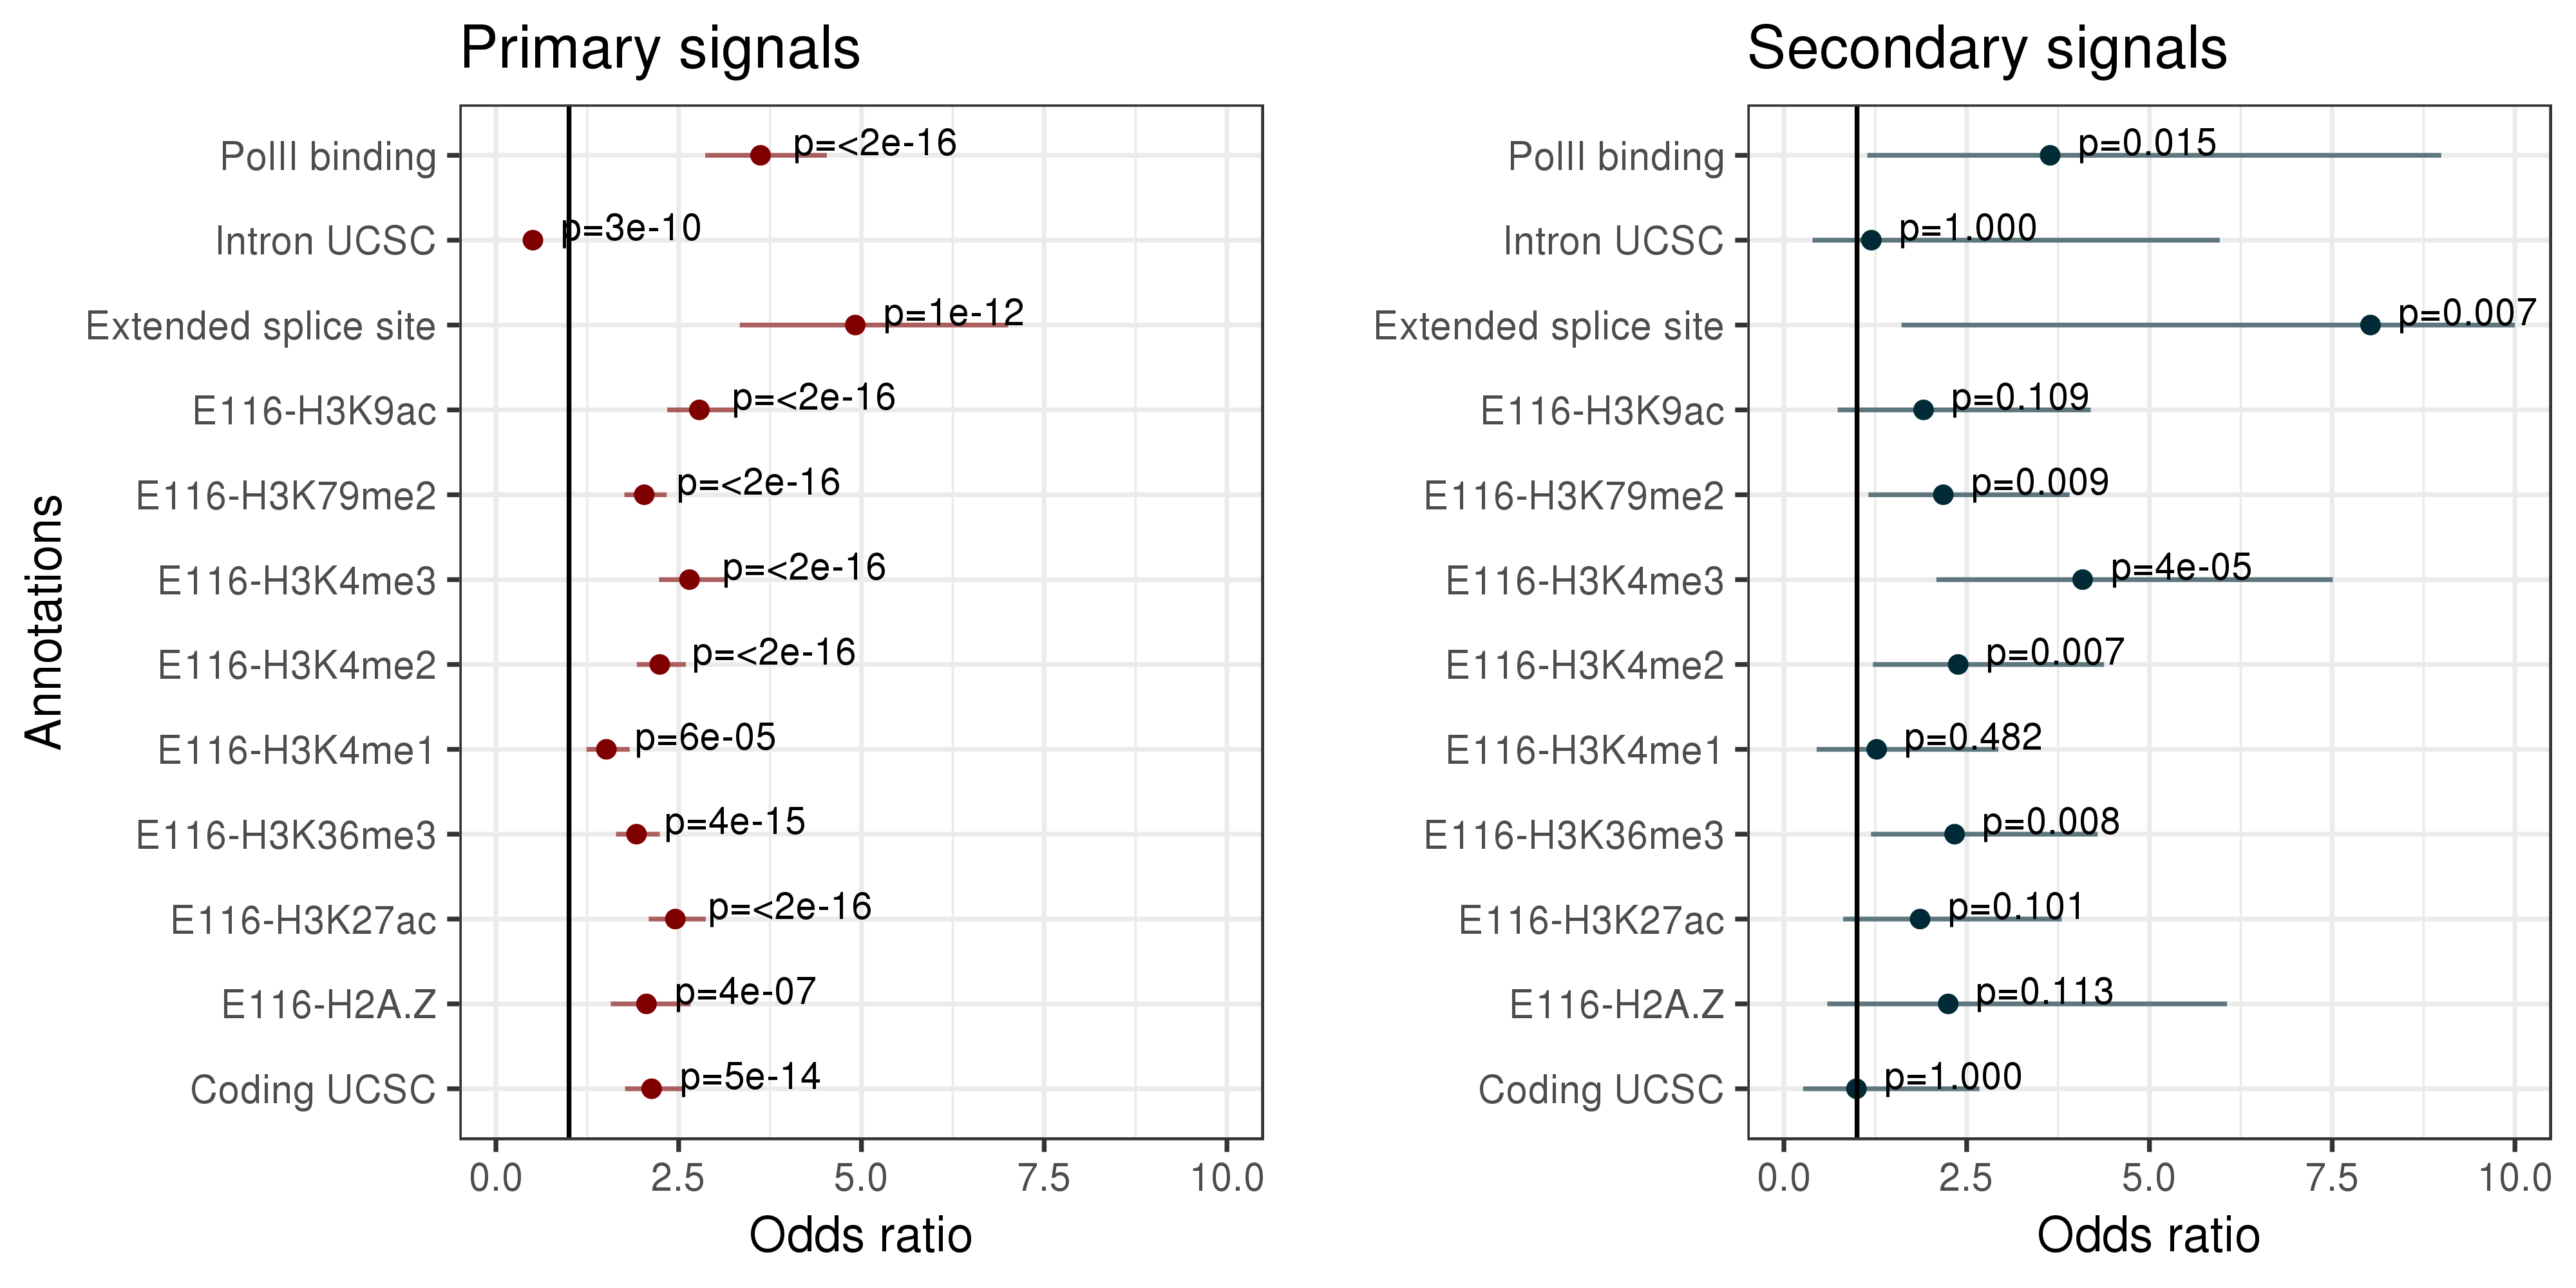

In [2]:
%preview /project/compbio/jointLCLs/results/SuSiE/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF_100Kb/enrichment/SuSiE_loci.sumstats.cs_fisher_test.png

## Check for overlap between signals identifyed by Li 2016

Data download from the [paper's companion data website](http://eqtl.uchicago.edu/jointLCL/output_ASintron_PC3.txt).

```
sos run analysis/20180712_Enrichment_Workflow.ipynb signal_overlap \
    --trait $trait --y-data $ydata -j $ncpu --cwd $cwd
```

In [ ]:
[signal_overlap_1 (download Li 2016 results)]
output: f'{cwd}/output_ASintron_PC3.txt'
download: dest_dir = f"{_output:d}"
    http://eqtl.uchicago.edu/jointLCL/output_ASintron_PC3.txt

In [ ]:
[signal_overlap_2]
depends: z_score
parameter: fdr = 0.0001
python: expand = "${ }"
    from sos.utils import get_output
    susie = set(get_output("zcat ${z_score} | cut -f2,3 -d'_' | sed 's/_/./g'").strip().split("\n"))
    yang = get_output("awk '{if ($5 < ${fdr}) print $1,$2}' ${_input}").strip().split('\n')[1:]
    yang_dict = dict()
    for line in yang:
        line = line.split()
        if line[1] not in yang_dict:
            yang_dict[line[1]] = []
        yang_dict[line[1]].append(line[0])
    intersects = []
    for key in yang_dict:
        common = susie.intersection(yang_dict[key])
        intersects.append(len(common) > 0)
    print(len(intersects))
    print(sum(intersects))

- for fdr 0.01, 1934 out of 2437 clusters match (79%)
- for fdr 0.001, 1324 out of 1494 clusters match (89%)
- for fdr 1E-4, 1007 out of 1111 clusters match (91%)